# This code will use SDXL1.0, ControlNet, and llama.cpp with StableBeluga to convert a company logo into a custom work of art.\

If you want to run this on Amazon Sagemaker, you will need to use a traditional Jupyter Notebook environment on an ml.g5.xlarge or bigger. Otherwise, this notebook runs natively in a Goolge Colab with a T4 GPU.

## Install dependencies:


In [1]:
!pip3 install transformers pillow torch numpy diffusers accelerate llama-cpp-python requests tqdm

## Define Functions


In [2]:
from PIL import Image

def load_bw_image(image_path):
    # Open the image
    img = Image.open(image_path)

    # Convert the image to black and white (1-bit pixels)
    bw_img = img.convert('1')

    return bw_img



In [3]:
import requests
from tqdm import tqdm

def download_and_save(url, save_path):
    """
    Download a file from the given URL and save it to the specified path, with a progress bar.

    Parameters:
    - url (str): The URL of the file to download.
    - save_path (str): The path where the downloaded file should be saved.
    """
    response = requests.get(url, stream=True)
    response.raise_for_status()  # Raise an exception for HTTP errors

    # Get the total size of the file from the response headers (if available)
    total_size = int(response.headers.get('content-length', 0))

    # Use tqdm to show the progress bar
    with open(save_path, 'wb') as file, tqdm(
        desc=save_path,
        total=total_size,
        unit='B',
        unit_scale=True,
        unit_divisor=1024,
    ) as bar:
        for chunk in response.iter_content(chunk_size=8192):
            file.write(chunk)
            bar.update(len(chunk))


In [4]:
import torch
from PIL import Image
import random
from diffusers import (
    DiffusionPipeline,
    AutoencoderKL,
    StableDiffusionControlNetPipeline,
    StableDiffusionXLControlNetPipeline,
    ControlNetModel,
    StableDiffusionLatentUpscalePipeline,
    StableDiffusionImg2ImgPipeline,
    StableDiffusionXLImg2ImgPipeline,
    StableDiffusionControlNetImg2ImgPipeline,
    StableDiffusionXLControlNetImg2ImgPipeline,
    DPMSolverMultistepScheduler,  # <-- Added import
    EulerDiscreteScheduler  # <-- Added import
)
import time

# Sampler map
SAMPLER_MAP = {
    "DPM++ Karras SDE": lambda config: DPMSolverMultistepScheduler.from_config(config, use_karras=True, algorithm_type="sde-dpmsolver++"),
    "Euler": lambda config: EulerDiscreteScheduler.from_config(config),
}

def center_crop_resize(img, output_size=(512, 512)):
    width, height = img.size

    # Calculate dimensions to crop to the center
    new_dimension = min(width, height)
    left = (width - new_dimension)/2
    top = (height - new_dimension)/2
    right = (width + new_dimension)/2
    bottom = (height + new_dimension)/2

    # Crop and resize
    img = img.crop((left, top, right, bottom))
    img = img.resize(output_size)

    return img

def common_upscale(samples, width, height, upscale_method, crop=False):
        if crop == "center":
            old_width = samples.shape[3]
            old_height = samples.shape[2]
            old_aspect = old_width / old_height
            new_aspect = width / height
            x = 0
            y = 0
            if old_aspect > new_aspect:
                x = round((old_width - old_width * (new_aspect / old_aspect)) / 2)
            elif old_aspect < new_aspect:
                y = round((old_height - old_height * (old_aspect / new_aspect)) / 2)
            s = samples[:,:,y:old_height-y,x:old_width-x]
        else:
            s = samples

        return torch.nn.functional.interpolate(s, size=(height, width), mode=upscale_method)

def upscale(samples, upscale_method, scale_by):
        #s = samples.copy()
        width = round(samples["images"].shape[3] * scale_by)
        height = round(samples["images"].shape[2] * scale_by)
        s = common_upscale(samples["images"], width, height, upscale_method, "disabled")
        return (s)

# Inference function
def generate_marketing_image(
    main_pipe,
    image_pipe,
    control_image: Image.Image,
    prompt: str,
    negative_prompt: str,
    guidance_scale: float = 8.0,
    controlnet_conditioning_scale: float = 1,
    control_guidance_start: float = 0,
    control_guidance_end: float = 1,
    upscaler_strength: float = 1,
    seed: int = -1,
    sampler = "DPM++ Karras SDE",
):
    start_time = time.time()
    start_time_struct = time.localtime(start_time)
    start_time_formatted = time.strftime("%H:%M:%S", start_time_struct)
    print(f"Inference started at {start_time_formatted}")

    # Generate the initial image
    #init_image = init_pipe(prompt).images[0]

    control_image_small = center_crop_resize(control_image)
    control_image_large = center_crop_resize(control_image, (1024, 1024))

    main_pipe.scheduler = SAMPLER_MAP[sampler](main_pipe.scheduler.config)
    my_seed = random.randint(0, 2**32 - 1) if seed == -1 else seed
    generator = torch.Generator(device="cuda").manual_seed(my_seed)

    out = main_pipe(
        prompt=prompt,
        negative_prompt=negative_prompt,
        image=control_image_small,
        guidance_scale=float(guidance_scale),
        controlnet_conditioning_scale=float(controlnet_conditioning_scale),
        generator=generator,
        control_guidance_start=float(control_guidance_start),
        control_guidance_end=float(control_guidance_end),
        num_inference_steps=15,
        output_type="latent"
    )
    upscaled_latents = upscale(out, "nearest-exact", 2)
    out_image = image_pipe(
        prompt=prompt,
        negative_prompt=negative_prompt,
        control_image=control_image_large,
        image=upscaled_latents,
        guidance_scale=float(guidance_scale),
        generator=generator,
        num_inference_steps=20,
        strength=upscaler_strength,
        control_guidance_start=float(control_guidance_start),
        control_guidance_end=float(control_guidance_end),
        controlnet_conditioning_scale=float(controlnet_conditioning_scale)
    )
    end_time = time.time()
    end_time_struct = time.localtime(end_time)
    end_time_formatted = time.strftime("%H:%M:%S", end_time_struct)
    print(f"Inference ended at {end_time_formatted}, taking {end_time-start_time}s")



    return out_image["images"][0]



## Execute

In [5]:
#We'll be using this model
llama_model_url="https://huggingface.co/TheBloke/StableBeluga-7B-GGUF/resolve/main/stablebeluga-7b.Q5_K_M.gguf"
filename=llama_model_url.split("/")[-1]


imageurl = None#input("Please enter a URL to the company logo: ")
companyname="Stability.ai"#input("Please enter the Company Name")

if not imageurl:
    #imageurl = "/content/Logo_S._CMYK.png"
    #"https://imgs.search.brave.com/Vz_A4xsB9bjgUx5pilsVraOhgZejW-coIa1SQJMaC-k/rs:fit:860:0:0/g:ce/aHR0cHM6Ly9pLnBp/bmltZy5jb20vb3Jp/Z2luYWxzL2FkLzJk/LzJlL2FkMmQyZWMy/MjU4Mzc5NTRiNTUy/Yjg1YjVkZGE1ZTNj/LS1tY2RvbmFsZHMt/ZnJlZWJpZXMuanBn"
    imageurl= "https://avatars.githubusercontent.com/u/100950301?s=200&v=4"

In [6]:
download_and_save(llama_model_url,filename)

stablebeluga-7b.Q5_K_M.gguf: 100%|██████████| 4.45G/4.45G [01:01<00:00, 77.5MB/s]


In [7]:
promptstring = "Can you please come up with a stable diffusion prompt for a themed image around the industry of "+companyname+"? Don't include "+companyname+" in the prompt. Try to make it as visually interesting and thematically focused as possible on "+companyname+". Your prompt:"

In [8]:
positive_prompt=""
from llama_cpp import Llama
llm = Llama(model_path=filename)
while len(positive_prompt)<10:
    output = llm(promptstring, max_tokens=100, echo=False,seed=-1)
    positive_prompt=output['choices'][0]['text']
negative_prompt="low quality, bad quality, sketches"
llm=None
print(positive_prompt)
print(negative_prompt)

AVX = 1 | AVX2 = 1 | AVX512 = 0 | AVX512_VBMI = 0 | AVX512_VNNI = 0 | FMA = 1 | NEON = 0 | ARM_FMA = 0 | F16C = 1 | FP16_VA = 0 | WASM_SIMD = 0 | BLAS = 0 | SSE3 = 1 | SSSE3 = 1 | VSX = 0 | 



"A whimsical exploration of the digital art revolution sparked by Stability.ai, capturing the fascinating journey of how this groundbreaking platform has transformed our perceptions of creativity."
low quality, bad quality, sketches


In [9]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("summarization", model="facebook/bart-large-cnn")

In [10]:
# Perform summarization
max_length = max(int(len(positive_prompt)/5)-10,1)
min_length = int(max_length/2)
summary = pipe(positive_prompt,max_length=max_length,min_length=min_length)

# Print the summarized text
positive_prompt=summary[0]['summary_text']
print(positive_prompt)

"A whimsical exploration of the digital art revolution sparked by Stability.ai"


In [11]:
download_and_save(imageurl,"logo")
input_image=load_bw_image("logo")


logo: 100%|██████████| 5.12k/5.12k [00:00<00:00, 4.94MB/s]


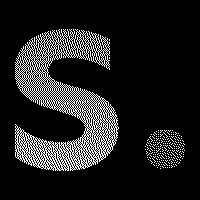

In [12]:
input_image

In [13]:
from PIL import Image, ImageOps
input_image = ImageOps.invert(input_image)

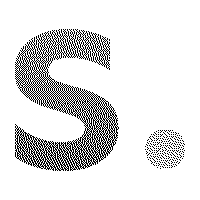

In [14]:
input_image

In [15]:
input_image=center_crop_resize(input_image,output_size=(1024,1024))

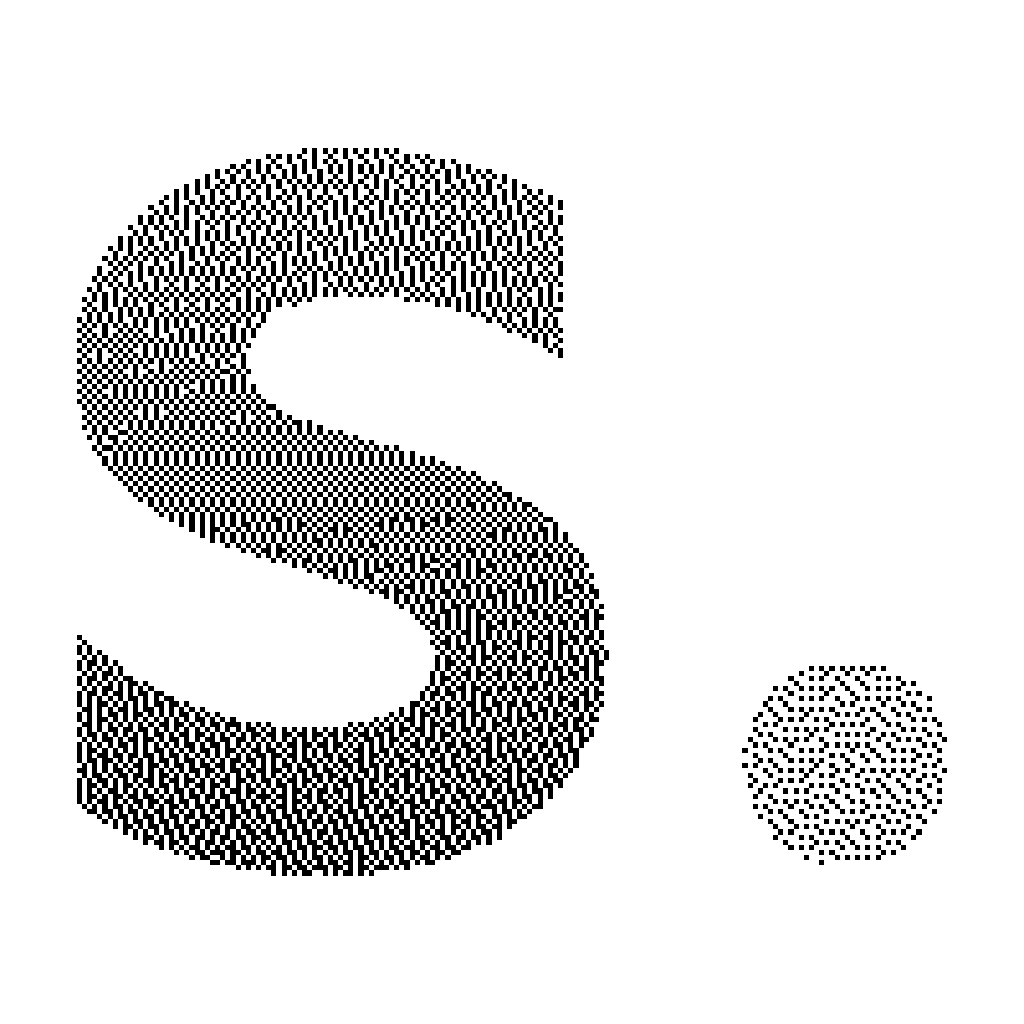

In [16]:
input_image

In [17]:
#we need to use the sdxl1.0 base model...
BASE_MODEL = "stabilityai/stable-diffusion-xl-base-1.0"

#"SG161222/Realistic_Vision_V5.1_noVAE"

# Initialize both pipelines
#we need to use the sdxl1.0 vae...
vae = AutoencoderKL.from_pretrained("stabilityai/sdxl-vae", torch_dtype=torch.float16)
#vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse", torch_dtype=torch.float16)
#init_pipe = DiffusionPipeline.from_pretrained("SG161222/Realistic_Vision_V5.1_noVAE", torch_dtype=torch.float16)

#we need a controlnetmodel which is compatible with sdxl1.0
#controlnet = ControlNetModel.from_pretrained("monster-labs/control_v1p_sd15_qrcode_monster", torch_dtype=torch.float16)#, torch_dtype=torch.float16)
#Nacholmo/controlnet-qr-pattern-sdxl
#monster-labs/control_v1p_sdxl_qrcode_monster
controlnet = ControlNetModel.from_pretrained("Nacholmo/controlnet-qr-pattern-sdxl", torch_dtype=torch.float16)#, torch_dtype=torch.float16)

main_pipe = StableDiffusionXLControlNetPipeline.from_pretrained(
    BASE_MODEL,
    controlnet=controlnet,
    vae=vae,
    torch_dtype=torch.float16,
).to("cuda")

#main_pipe.unet = torch.compile(main_pipe.unet, mode="reduce-overhead", fullgraph=True)
#main_pipe.unet.to(memory_format=torch.channels_last)
#main_pipe.unet = torch.compile(main_pipe.unet, mode="reduce-overhead", fullgraph=True)
#model_id = "stabilityai/sd-x2-latent-upscaler"

image_pipe = StableDiffusionXLControlNetImg2ImgPipeline(**{i:main_pipe.components[i] for i in main_pipe.components if i!="feature_extractor" and i!="image_encoder"})

#image_pipe.unet = torch.compile(image_pipe.unet, mode="reduce-overhead", fullgraph=True)
#upscaler = StableDiffusionLatentUpscalePipeline.from_pretrained(model_id, torch_dtype=torch.float16)
#upscaler.to("cuda")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [18]:
output_image=generate_marketing_image(main_pipe=main_pipe,image_pipe=image_pipe,control_image=input_image,prompt=positive_prompt,negative_prompt=negative_prompt)

Inference started at 01:26:33


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Inference ended at 01:27:04, taking 30.365452527999878s


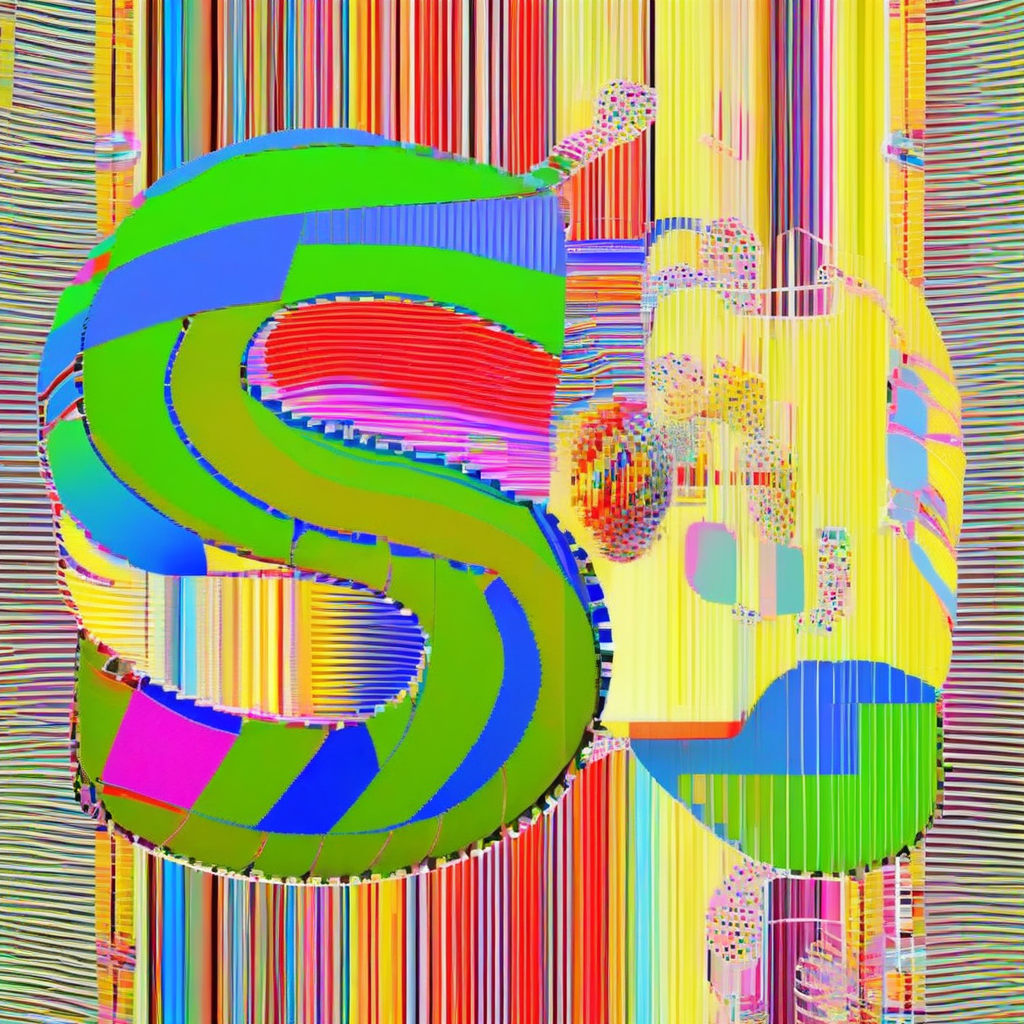

In [19]:
output_image